# Scene generation model




- pre-trained transformer based on the GPT-2 language model to generate new scenes from the TV show "The Office."
- data preparation by concatenating each scene into one row and keeping directorials
- fine-tuneing with an AdamW optimizer on tokenized data

# Setup

In [7]:
import os
import time
import datetime


import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt


import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\schla\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Create Training Set

In [3]:
import sys
sys.path.append("..")

from preprocessing_nlp import preprocess, extract_features
from utils import print_episode

PATH = "../data/"
FILE = "the-office-lines_scripts.csv"

In [17]:
df_raw = pd.read_csv(PATH+FILE, sep=",", index_col='id')
df = preprocess(df_raw, concat_scenes=True)
df_sea = df_raw.copy()
df_sea["season_episode"] = df_sea.apply(lambda x: f"{x['season']}{'0' if x['episode']<10 else ''}{x['episode']}", axis=1)
df.dropna(inplace=True) 

In [18]:
df

,season,episode,scene,line_text,season_episode
0,1,1,1,[Michael]: All right Jim. Your quarterlies loo...,101
1,1,1,2,"[Michael]: [on the phone] Yes, I'd like to spe...",101
2,1,1,3,"[Michael]: I've, uh, I've been at Dunder Miffl...",101
3,1,1,4,[Michael]: People say I am the best boss. They...,101
4,1,1,5,[Dwight]: [singing] Shall I play for you? Pa r...,101
...,...,...,...,...,...
8844,9,23,112,[Creed]: It all seems so very arbitrary. I app...,923
8845,9,23,113,[Meredith]: I just feel lucky that I got a cha...,923
8846,9,23,114,[Phyllis]: I m happy that this was all filme...,923
8847,9,23,115,[Jim]: I sold paper at this company for 12 yea...,923


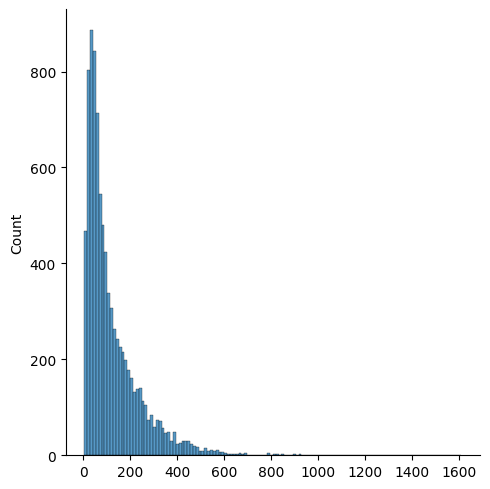

In [19]:
doc_lengths = []

for line in df['line_text']:
    # get rough token count distribution
    tokens = nltk.word_tokenize(line)
    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.displot(doc_lengths)

In [20]:
# the max token length   
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.0028251779862131315

In [21]:
np.average(doc_lengths)

124.7820092665838

# GPT2 Tokenizer

In [ ]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium


In [23]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


# PyTorch Datasets & Dataloaders


In [24]:
batch_size = 5

- using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).
- passing in the tokenizer as an argument but normally I would  instantiate it within the class.

In [25]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=512):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [27]:
dataset = GPT2Dataset(df['line_text'], tokenizer, max_length=512)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

7,964 training samples
  885 validation samples


In [28]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [30]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model.resize_token_embeddings(len(tokenizer))
device = torch.device("cpu")

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)

# Finetune GPT2 Language Model

In [22]:
epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8
sample_every = 500

optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [24]:
tokenizer.bos_token_id, tokenizer.eos_token_id, tokenizer.pad_token_id

(50257, 50256, 50258)

In [25]:
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [26]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [27]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=tokenizer.bos_token_id,
                                    pad_token_id=tokenizer.pad_token_id,
                                    eos_token_id=tokenizer.eos_token_id,
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("Saving model...")

    torch.save(model.state_dict(), f'model_epoch_{epoch_i}.pth')
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...
  Batch   500  of  1,593. Loss: 0.42338404059410095.   Elapsed: 0:02:26.
0: [ Dwight ] : Whoa.
  Batch 1,000  of  1,593. Loss: 0.4674864411354065.   Elapsed: 0:04:53.
0: [ Dwight ] : Hey guys, everyone. [ Karen ] : What? [ Dwight ] : [ nervous ] [ Karen ] : Good, I good news. Yeah, okay. [ Dwight ] : Uh, I. [ Karen ] : I really disappointed. What I meant? [ Dwight ] : Oh, I think. [ Karen ] : Well, I think, I think, I feel like. [ Dwight ] : And, um,... um. That I thinking?
  Batch 1,500  of  1,593. Loss: 0.6733189225196838.   Elapsed: 0:07:20.
0: [ Michael ] : What time day? [ Ryan ] : I little bit late getting information. [ Michael ] : Good. It uh, know? Good, enough, let us go go, take care, okay? [ Ryan ] : Thank... [ Michael ] : [ laughs ] And... yeah, let us go, go. [ Ryan ] : Yeah, I really sorry. You know, I... I... I sorry I going. Okay. Oh, good.

  Average training loss: 0.79
  Training epoch took: 0:07:48
Saving model...
Running V

In [48]:
torch.save(model.state_dict(), 'models/model_scene_generation.pth')

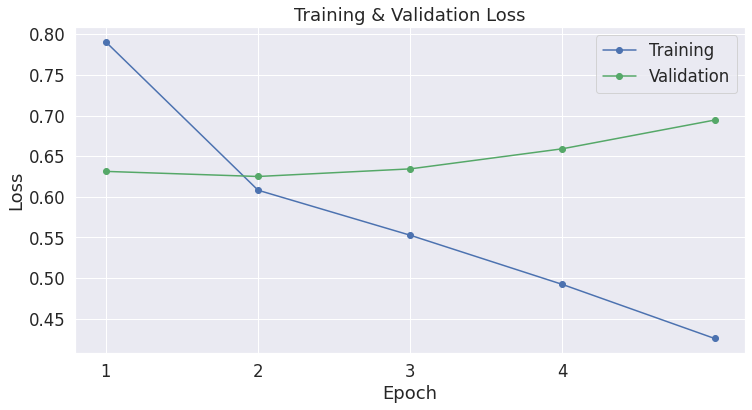

In [29]:
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [31]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 scene generation model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 scene generation model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight            

# Loading Fine-Tuned Model


In [49]:
# load already trained models from file

model.load_state_dict(torch.load('models/model_scene_generation.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

# Generate Text

In [59]:
model.eval()

from IPython import display
prompt = "Jim:"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                eos_token_id=tokenizer.eos_token_id,
                                bos_token_id=tokenizer.bos_token_id,
                                top_k=50, 
                                max_length = 100,
                                top_p=0.999, 
                                num_return_sequences=5,
                                mask_token_id=tokenizer.mask_token_id,
                                pad_token_id=tokenizer.pad_token_id,
                                temperature=0.7
                                )

for i, sample_output in enumerate(sample_outputs):
  print(tokenizer.decode(sample_output, skip_special_tokens=True))
  print("\n")


Jim: I will quit. Michael: Don't quit! That's...  heresy. Get off my property before I go.


Jim: So the monkey does a split and then the monkey just says 'Split the difference?' Angela: Monkey doesn't do a split! Kevin: Yeah! Angela: I hear it! Kevin: I hear it!


Jim: And the 'Tight Ass' award goes to Angela.  Not only because she's a very good screamer, but because she's also a plain hearty guy.  And the reason we pick those three people is because we think that none of them would be a stand up guy, and none of them are going to be able to tell us what it is really like to be a stand up guy.  So we go with Toby.  Who stands up to Angela?  Toby


Jim: Is that scented? Angela: No. I think it smells like cigarettes.


Jim: Okay, so you're not going to reveal what you're doing to her, but if you did, then you're a big flan. I'm not going to make any decision until after you've had a great deal of fun. Hide: Diwali is a festival of lights. Why not? Because it's a very important holiday f

Generated scene:

Promt: 'Michael: Thats it! I am back!'
> Dwight: Ah, thank you! So long.<br>
> Angela: Extension 128.<br>
> Creed: Hiya Pumpkin.<br>
> Angela: You doing great?<br>
> Creed: Yeah. So, do you want to hear me sing in your sexy sexy sexy highness?<br>
> Angela: No.<br>

Similar scene from the real show with the same characters

In [18]:
print_episode(df_sea, '302', 9)

[Creed]: There's my girl. I noticed you handing out some shekels. How would one get on that train?
[Angela]: That was for per diem, for Philadelphia.
[Meredith]: That town smells like cheese steaks.
[Angela]: That town is full of history!
[Creed]: Andrea's the office bitch. You'll get used to her. [introducing himself] Creed.


- model successfully imitates the speaking styles of different characters

Prompt: 'Michael: Let's get back to work.'
> Michael: Let's get back to work.  Where are you? <br>
> Jim: I'm here. <br>
> Andy: Fine. <br>
> Jim: I just need a second. <br>
> Andy: That's gotta be between you and Pam. <br>
> Jim: Okay, yeah. Andy: Hmm.  Alright! <br>
> Jim: This is it. <br>
> Pam: This is where we work.  This is where we'll be meeting.  What is your commute like? <br>
> Jim: It's really good. <br>
> Pam: Oh, your ears are so sweaty. <br>
> Jim: Oh, my God. <br> 

Prompt: 'Jim:'
>Jim: I don't think it even matters. <br>
>Dwight: People died there, people died here. <br>
>Jim: Oh... You keep saying the office is no better, but don't... <br>
>Dwight: No it's better than the rest of the... <br>
>Jim: I'm sorry. I... I'm really sorry. <br>
>Dwight: Yeah, well, if it makes us feel better, don't be a jerk. This is a place where we can all die together. A place where we can all be happy. <br>
>Jim: Yeah, right. <br>